In [1]:
from numpy.random.mtrand import vonmises
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

def quadratic(x, a):
    return 0.5 * np.dot(x - a, x - a)

def quadratic_gradient(x, a):
    return x - a

def stochastic_quadratic_gradient(x):
    noise = np.zeros(d)
    noise[0] = np.random.normal()*100
    return x + noise


def quadratic1(x):
    return quadratic(x, 1)

def quadratic5(x):
    return quadratic(x, 5)

def quadratic10(x):
    return quadratic(x, 10)


def quadratic_gradient1(x):
    return quadratic_gradient(x, 1)

def quadratic_gradient5(x):
    return quadratic_gradient(x, 5)

def quadratic_gradient10(x):
    return quadratic_gradient(x, 10)

def aggregate_functions1(x):
    return 1/3 * (quadratic1(x) + quadratic5(x) + quadratic10(x))


def aggregate_gradients1(x):
    return 1/3 * (quadratic_gradient1(x) + quadratic_gradient5(x) + quadratic_gradient10(x))



def processRuns(runs):
    mean = np.mean(runs,axis=1)
    std = np.std(runs,axis=1)
    return mean, std


def plot_graphs(x, y, title, xlabel, ylabel, legend_labels, d=100, save_title="default", baseline=True):
    plt.figure()
    matplotlib.rcParams.update({'font.size': 12})
    n = len(x)
    
    for i in range(n):
        plt.plot(x[i], y[i], label=legend_labels[i])
    
    if baseline:
        plt.axhline(y= 6100/9, color='mediumorchid', linestyle='--', alpha=0.5, label=r"$F^*$")
    plt.ticklabel_format(useOffset=False)
    plt.title(title)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.savefig(save_title + ".pdf")



def sparse_top_k(arr, k):
    n = len(arr)
    top_k_indices = sorted(range(n), key=lambda i: abs(arr[i]))[-k:]
    mask_array =  np.full(n, False, dtype=bool)

    mask_array[top_k_indices] = True

    return np.multiply(mask_array, arr), np.multiply(~mask_array, arr)


def sparsification_twoway(obj, sto, lr, k, d, N_steps, repeats, sigma=5, decay=False):
    runs = np.zeros([N_steps,repeats])

    rruns = np.zeros([N_steps,repeats])
    lruns = np.zeros([N_steps,repeats])
    l2runs = np.zeros([N_steps,repeats])

    for rep in range(repeats):
        v = np.full(d, starting_point, dtype=float) + np.random.normal(0, sigma, d)
        e = np.zeros(d)

        ed = np.zeros((3, d))
        f_values = []
        l = []
        l2 = []
        r = []

        for step in range(N_steps):
            f_values.append(aggregate_functions1(v))

            total = np.zeros(d)
            total_without_sparsity = np.zeros(d)
            i = 0
            for func in sto:
                acc = ed[i] + lr * func(v)
                update, _ = sparse_top_k(acc, k)
                ed[i] = acc - update
                total += update

                total_without_sparsity += acc

                i += 1
            
            
            sparse_total_without_sparsity, _ = sparse_top_k(total_without_sparsity/len(sto) + e, k)
            update = total/len(sto)

            update, t, t1 = total/len(sto), sparse_total_without_sparsity, total_without_sparsity/len(sto) + e
            update = update + e

            p, _ = sparse_top_k(update, k)
            e = update - p

            l.append(np.linalg.norm(p - t)) # 
            r.append(lr * np.linalg.norm(aggregate_gradients1(v))) #

            v -= p
 
        rruns[:,rep] = np.asarray(r) #
        lruns[:,rep] = np.asarray(l) # 
        runs[:,rep] = np.asarray(f_values)
    return runs, lruns, rruns


def sparsification_downstream(obj, sto, lr, k, d, N_steps, repeats, sigma=5, decay=False):
    runs = np.zeros([N_steps,repeats])
    for rep in range(repeats):
        v = np.full(d, starting_point, dtype=float) + np.random.normal(0, sigma, d)
        e = np.zeros(d)

        f_values = []
        for step in range(N_steps):
            f_values.append(aggregate_functions1(v))
            
            update = aggregate_gradients1(v)

            update = update + e

            p, _ = sparse_top_k(update, k)
            e = update - p

            v -= p * lr
            
        runs[:,rep] = np.asarray(f_values)
    return runs

def sparsification(obj, sto, lr, k, d, N_steps, repeats, decay=False, sigma=5, point = 325):
    runs = np.zeros([N_steps,repeats])
    
    erecord = np.zeros((3, d))
    vrecord = np.zeros(d)
    accrecord = np.zeros((3, d))

    for rep in range(repeats):
        v = np.full(d, starting_point, dtype=float) + np.random.normal(0, sigma, d)
        # v = np.random.normal(size=d)
        e = np.zeros((3, d))

        f_values = []
        
        for step in range(N_steps):
            f_values.append(aggregate_functions1(v))


            total = np.zeros(d)
            i = 0
            for func in sto:
                acc = e[i] + lr * func(v)
                if step == point:
                    vrecord = v
                    accrecord[i] = acc

                update, _ = sparse_top_k(acc, k)
                e[i] = acc - update
                
                total += update
                i += 1
                

            update = total/len(sto) 

            v -= update

        runs[:,rep] = np.asarray(f_values)
    return runs, vrecord, accrecord


def plot_value(x, d, xlabel, component, baseline=False, savefig="file"):
    matplotlib.rcParams.update({'font.size': 14})
    color = ["dodgerblue"] * 100
    
    for c in component:
        color[c] = "tomato"

    plt.figure(figsize=(6, 4))
    plt.bar(list(range(1, d + 1)), x, width=0.5, color = color)
    if baseline:
        plt.axhline(y=16/3, color='black', linestyle='--')
    plt.grid()
    # plt.ylabel("magnitude")
    plt.xlabel(xlabel)
    plt.savefig(savefig + ".pdf", bbox_inches='tight')


def plot_gradients(x, d, xlabel, component, baseline=False):
    matplotlib.rcParams.update({'font.size': 16})

    color = ["dodgerblue"] * 100
    # color[component] = "tomato"
    fig, axs = plt.subplots(1, 3, figsize=(20,5), sharey=True)

    axs[0].bar(list(range(1, d + 1)), x[0], width=0.5, color = color)
    axs[0].grid()
    axs[0].set_xlabel("Worker 1")
    axs[1].bar(list(range(1, d + 1)), x[1], width=0.5, color = color)
    axs[1].grid()
    axs[1].set_xlabel("Worker 2")
    axs[2].bar(list(range(1, d + 1)), x[2], width=0.5, color = color)
    axs[2].grid()
    axs[2].set_xlabel("Worker 3")

    fig.text(0.5,  -0.02, xlabel, ha='center')
    matplotlib.rcParams.update({'font.size': 14})
    plt.savefig("gradients_frozen_frame.pdf", bbox_inches='tight')


def sparsification_record(obj, sto, lr, k, d, N_steps, repeats, sigma=5, decay=False):
    runs = np.zeros([N_steps,repeats])
    rruns = np.zeros([N_steps,repeats])
    lruns = np.zeros([N_steps,repeats])
    
    for rep in range(repeats):
        v = np.full(d, starting_point, dtype=float) + np.random.normal(0, sigma, d)
        e = np.zeros((3, d))

        def aggregate_sparse_gradients(x, step, funcs):
            total = np.zeros(d)

            total_without_sparsity = np.zeros(d)

            i = 0
            for func in funcs:
                acc = e[i] + lr * func(x)
                update, _ = sparse_top_k(acc, k)
                e[i] = acc - update
                
                total_without_sparsity += acc
                total += update

                i += 1

            sparse_total_without_sparsity, _ = sparse_top_k(total_without_sparsity/len(funcs), k)
            return total/len(funcs), sparse_total_without_sparsity

        f_values = []
        l = []
        r = []
        for step in range(N_steps):
            f_values.append(aggregate_functions1(v))
            update, t = aggregate_sparse_gradients(v, step, sto)
            
            l.append(np.linalg.norm(update - t))
            r.append(lr * np.linalg.norm(aggregate_gradients1(v)))

            v -= update

        rruns[:,rep] = np.asarray(r)
        lruns[:,rep] = np.asarray(l)
        runs[:,rep] = np.asarray(f_values)
    return runs, lruns, rruns


def sparsification_twoway_record(obj, sto, lr, k, d, N_steps, repeats, decay=False):
    runs = np.zeros([N_steps,repeats])
    rruns = np.zeros([N_steps,repeats])
    lruns = np.zeros([N_steps,repeats])
    
    for rep in range(repeats):
        v = np.full(d, starting_point, dtype=float)
        e = np.zeros(d)
        ed = np.zeros((3, d))

        def aggregate_sparse_gradients(x, step, funcs):
            total = np.zeros(d)
            total_without_sparsity = np.zeros(d)

            i = 0
            for func in funcs:
                acc = ed[i] + lr * func(x)
                update, _ = sparse_top_k(acc, k)
                ed[i] = acc - update
                
                total_without_sparsity += acc
                total += update

                i += 1

            sparse_total_without_sparsity, _ = sparse_top_k(total_without_sparsity/len(funcs) + e, k)

            return total/len(funcs), sparse_total_without_sparsity

        f_values = []
        l = []
        r = []
        for step in range(N_steps):
            f_values.append(aggregate_functions1(v))
            update, t = aggregate_sparse_gradients(v, step, sto)

            update = update + e

            p, _ = sparse_top_k(update, k)
            e = update - p


            l.append(np.linalg.norm(p - t))
            r.append(lr * np.linalg.norm(aggregate_gradients1(v)))

            v -= p

        # rruns and lruns are the left and right side of the equation
        rruns[:,rep] = np.asarray(r)
        lruns[:,rep] = np.asarray(l)
        runs[:,rep] = np.asarray(f_values)
    return runs, lruns, rruns

In [2]:
N_steps = 1000
repeats = 1
starting_point = 20
seed = 10
sigma=1

np.random.seed(seed)
sparse_f, l_two_way, r_two_way = sparsification_twoway([quadratic1, quadratic5, quadratic10], [quadratic_gradient1, quadratic_gradient5, quadratic_gradient10], lr=0.01, k=1, d=100,  N_steps=N_steps, repeats=repeats, sigma=sigma, decay=False)
sparse_twoway_mean, sparse_twoway_var = processRuns(sparse_f)

np.random.seed(seed)
sparse_f, l_one_way, r_one_way = sparsification_record([quadratic1, quadratic5, quadratic10], [quadratic_gradient1, quadratic_gradient5, quadratic_gradient10], lr=0.01, k=1, d=100,  N_steps=N_steps, repeats=repeats, sigma=sigma, decay=False)
sparse_oneway_mean, sparse_oneway_var = processRuns(sparse_f)  

np.random.seed(seed)
sparse_f = sparsification_downstream([quadratic1, quadratic5, quadratic10], [quadratic_gradient1, quadratic_gradient5, quadratic_gradient10], lr=0.01, k=1, d=100,  N_steps=N_steps, repeats=repeats, decay=False)
sparse_oneway_d_mean, sparse_oneway_d_var = processRuns(sparse_f) 

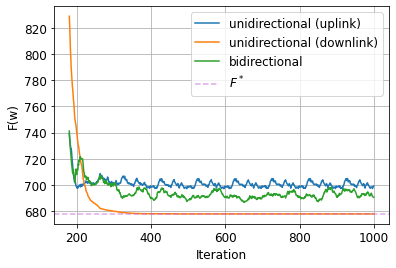

In [3]:
iterations = list(range(N_steps))
start = 180 
end = 1000
plot_graphs([iterations[start:end], iterations[start:end], iterations[start:end]], [sparse_oneway_mean[start:end], sparse_oneway_d_mean[start:end], sparse_twoway_mean[start:end]], "", "Iteration", "F(w)", ["unidirectional (uplink)", "unidirectional (downlink)", "bidirectional"], d = 100, save_title="toy_example", baseline=True)

In [4]:
def batch_to_epoch_avg(arr, num, ignore_first=False):
    if len(arr) == 0:
        return []

    i = 0
    epoch_vals = []
    while i + num <= len(arr):
        if ignore_first:
            if i == 0:
                epoch_vals.append(sum(arr[i + 1: i+num]) / (num - 1))
            else:
                epoch_vals.append(sum(arr[i + 1: i+num]) / num)
        else:
            epoch_vals.append(sum(arr[i + 1: i+num]) / num)
        i = i + num

    return epoch_vals


def batch_to_epoch(arr, num, ignore_first=False):
    if len(arr) == 0:
        return []

    i = 0
    epoch_vals = []
    while i + num <= len(arr):
        if ignore_first:
            if i == 0:
                epoch_vals.append(max(arr[i+1: i+num]))
            else:
                epoch_vals.append(max(arr[i: i+num]))
        else:
            epoch_vals.append(max(arr[i: i+num]))
        i = i + num

    return epoch_vals



def batch_to_epoch_min(arr, n):
    i = 0
    epoch_vals = []
    while i + n <= len(arr):
        epoch_vals.append(min(arr[i: i+n]))
        i = i + n

    return epoch_vals


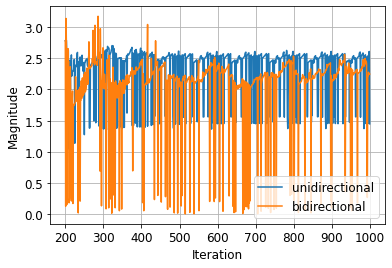

In [5]:
iterations = list(range(N_steps))
start = 200
end = 1000
two_way = np.mean(l_two_way,axis=1)[start:end]
one_way = np.mean(l_one_way,axis=1)[start:end]

plot_graphs([iterations[start:end], iterations[start:end]], [one_way, two_way], "", "Iteration", "Magnitude", ["unidirectional", "bidirectional"], d = 100, save_title="ratio", baseline=False)

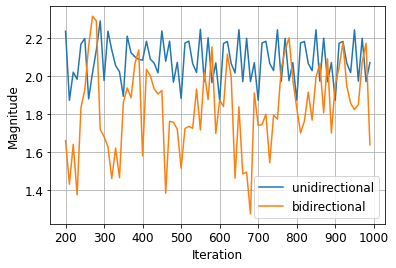

In [6]:
one_shortened = batch_to_epoch_avg(one_way, 10)
two_shortened = batch_to_epoch_avg(two_way, 10)


plot_graphs([list(range(start, 1000, 10)), list(range(start, 1000, 10))], [one_shortened, two_shortened], "", "Iteration", "Magnitude", ["unidirectional", "bidirectional"], d = 100, save_title="ratio_max", baseline=False)

In [7]:
seed=10
np.random.seed(seed)
sparse_f, v, acc = sparsification([quadratic1, quadratic5, quadratic10], [quadratic_gradient1, quadratic_gradient5, quadratic_gradient10], lr=0.01, k=1, d=100,  N_steps=N_steps, repeats=repeats, sigma=1, decay=False, point = 210)
sparse_oneway_mean, sparse_oneway_var = processRuns(sparse_f)

In [8]:
total = acc[1] + acc[2] + acc[0]
sparse_v = sparse_top_k(acc[0], 1)[0] + sparse_top_k(acc[1], 1)[0] + sparse_top_k(acc[2], 1)[0]
print(np.linalg.norm(total - sparse_v))
print(np.linalg.norm(total - sparse_top_k(sparse_v, 1)[0]))

21.797625612263886
21.54290474751246


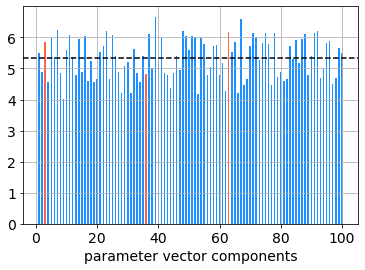

In [9]:
plot_value(v, 100, "parameter vector components", [np.argmax(abs(acc[0])), np.argmax(abs(acc[1])), np.argmax(abs(acc[2]))], baseline=True, savefig="vector_frozen_frame")

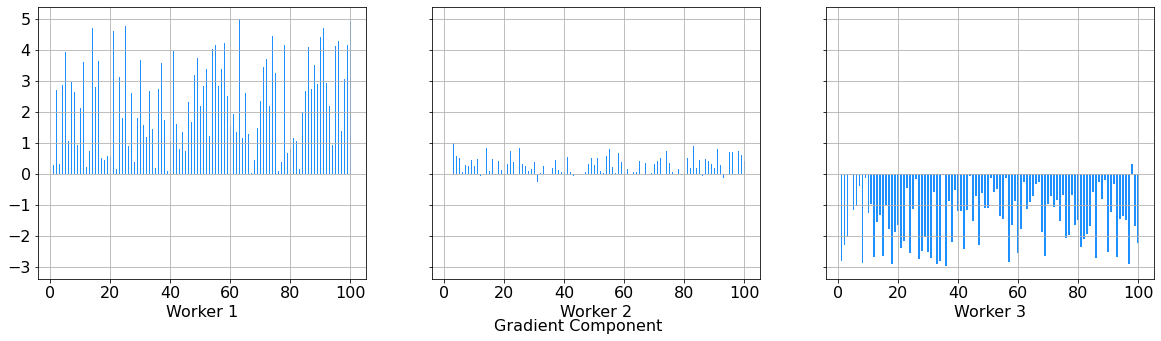

In [10]:
plot_gradients([acc[0],acc[1],acc[2]], 100, "Gradient Component", 0, False)

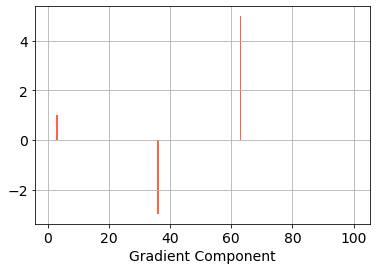

In [11]:
plot_value(sparse_v, 100, "Gradient Component", component=[np.argmax(abs(acc[0])), np.argmax(abs(acc[1])), np.argmax(abs(acc[2]))], savefig="sparse_frozen_frame")

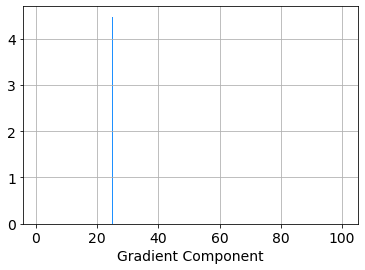

In [12]:
plot_value(sparse_top_k(total, 1)[0], 100, "Gradient Component", [np.argmax(abs(acc[0])), np.argmax(abs(acc[1])), np.argmax(abs(acc[2]))])

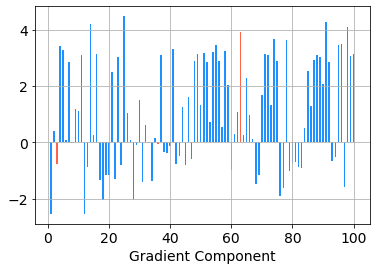

In [13]:
plot_value(total, 100, "Gradient Component", component=[np.argmax(abs(acc[0])), np.argmax(abs(acc[1])), np.argmax(abs(acc[2]))], savefig="gradient_sum_without_sparsification")